# Summary
LGMBClassifier trained on the breast cancer dataset achieved the following metrics:
|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| **B**        | 0.97      | 0.99   | 0.98     | 108     |
| **M**        | 0.98      | 0.95   | 0.97     | 63      |
| **Accuracy** |           |        | 0.98     | 171     |
| **Macro Avg**| 0.98      | 0.97   | 0.97     | 171     |
| **Weighted Avg** | 0.98   | 0.98   | 0.98     | 171     |

Adjusting n_estimators and SMOTE did not improve the performance of the model.

The rest of the notebook is organized as follows:
1. EDA
2. Training
3. Adjusting n_estimators with Optuna and using SMOTE

dataset from https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset

lunch basic mlflow server with 

mlflow server --host 127.0.0.1 --port 8080   

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import mlflow
mlflow.set_tracking_uri('http://localhost:8080')

In [2]:
df = pd.read_csv('breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Initial data checks
1. Check the column names and datatypes.
1. Check if there are nulls.
1. Check the cardinality of categorical columns.
1. Check the distribution of the target column.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
df.isnull().any().sum()

0

There is a slight imbalance in the data set.

<Axes: ylabel='diagnosis'>

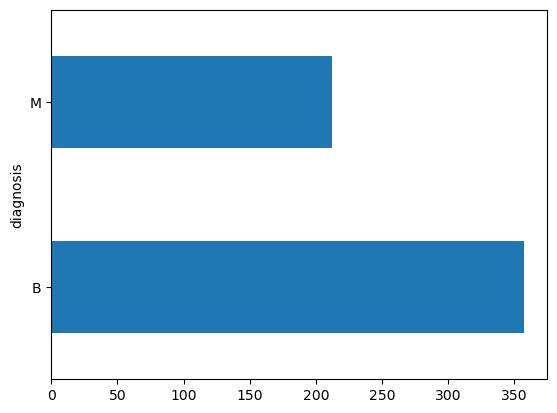

In [6]:
df.diagnosis.value_counts().plot(kind='barh')

# EDA

Check the correlation between columns. Use label encoder for the diagnosis column. There is a strong correlation between the diagnosis and other columns which is an indicator that a classifier might be able to learn this.

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
id                         0

<Axes: >

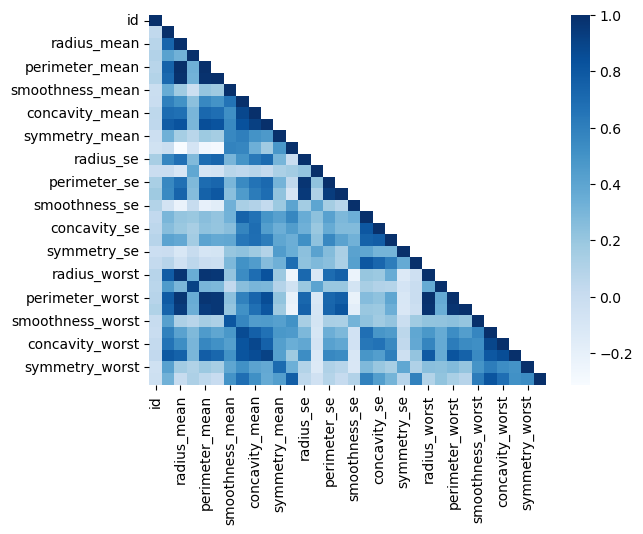

In [15]:
le = LabelEncoder()

copy_df = df.copy()
copy_df['diagnosis'] = le.fit_transform(copy_df['diagnosis'])

corr = copy_df.corr()
mask = np.triu(np.ones(corr.shape), k=1)
print(corr['diagnosis'].sort_values(ascending=False))
sns.heatmap(corr, mask=mask, cmap='Blues')



Box plot concave points_worst,  perimeter_worst, and concave points_mean since they are have the top correlation with diagnosis.  
The box plots show that there is a significant difference in the distribution for M and B for these features.

<Axes: xlabel='diagnosis', ylabel='concave points_mean'>

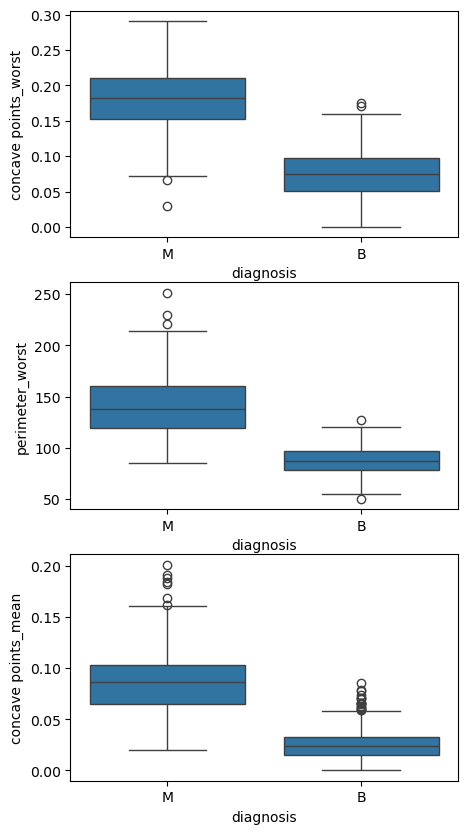

In [21]:
fig, axes = plt.subplots(3,1, figsize=(5, 10))
sns.boxplot(x=df['diagnosis'], y=df['concave points_worst'], ax=axes[0])
sns.boxplot(x=df['diagnosis'], y=df['perimeter_worst'], ax=axes[1])
sns.boxplot(x=df['diagnosis'], y=df['concave points_mean'], ax=axes[2])

# Training

In [52]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis'].to_frame()

# cat_cols = list(X.dtypes[X.dtypes == 'object'].keys())
num_cols = list(X.dtypes[X.dtypes == 'number'].keys())

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
# X_train[cat_cols] = X_train[cat_cols].apply(lambda col: col.astype('category'))
# X_valid[cat_cols] = X_valid[cat_cols].apply(lambda col: col.astype('category'))

sample_row = X.iloc[0,:].to_dict()

In [49]:
with mlflow.start_run():
    params = {
        'n_estimators': 300
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)

    report = classification_report(y_valid, preds, output_dict=True)
    for label, metrics in report.items():
            if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Exclude overall metrics if needed
                mlflow.log_metric(f"{label}_precision", metrics['precision'])
                mlflow.log_metric(f"{label}_recall", metrics['recall'])
                mlflow.log_metric(f"{label}_f1-score", metrics['f1-score'])
                mlflow.log_metric(f"{label}_support", metrics['support'])
    mlflow.log_params(params)

    mlflow.set_tag("Training Info", "Basic LGBMClassifier model for breast cancer dataset")

    signature = mlflow.models.infer_signature(X_train, model.predict(X_train))

    mlflow.lightgbm.log_model(model, artifact_path="model", signature=signature)

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schem

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4111
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374372 -> initscore=-0.513507
[LightGBM] [Info] Start training from score -0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

2024/10/28 08:24:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-roo-802 at: http://localhost:8080/#/experiments/0/runs/e62cb5bd93fd4d12a231ccbb2958254f.
2024/10/28 08:24:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


Initial results have already very high accuracy, precision, and recall.

{'B': {'precision': 0.9636363636363636, 'recall': 0.9814814814814815, 'f1-score': 0.9724770642201835, 'support': 108.0}, 'M': {'precision': 0.9672131147540983, 'recall': 0.9365079365079365, 'f1-score': 0.9516129032258065, 'support': 63.0}, 'accuracy': 0.9649122807017544, 'macro avg': {'precision': 0.965424739195231, 'recall': 0.9589947089947091, 'f1-score': 0.962044983722995, 'support': 171.0}, 'weighted avg': {'precision': 0.9649541140481607, 'recall': 0.9649122807017544, 'f1-score': 0.9647902680643604, 'support': 171.0}}


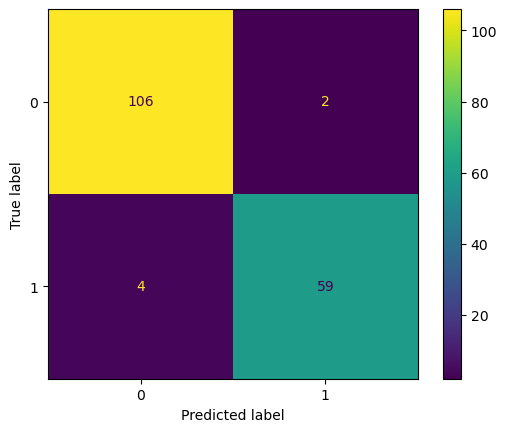

In [41]:
print(classification_report(y_valid, preds))
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

Use optuna to find a better n_estimator for the model.

In [28]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    clf = LGBMClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

n_estimators = study.best_trial.params['n_estimators']
print(f'n_estimators: {n_estimators}')
print(f'score: {study.best_trial.value}')

model = LGBMClassifier(n_estimators=n_estimators)
model.fit(X_train, y_train)


[I 2024-10-28 07:34:25,486] A new study created in memory with name: no-name-c9c99aff-d5cd-42d0-b20e-7afc14571569


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-10-28 07:34:25,591] Trial 0 finished with value: 0.9766081871345029 and parameters: {'n_estimators': 352}. Best is trial 0 with value: 0.9766081871345029.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4111
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374372 -> initscore=-0.513507
[LightGBM] [Info] Start training from score -0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-28 07:34:25,744] Trial 2 finished with value: 0.9766081871345029 and parameters: {'n_estimators': 280}. Best is trial 0 with value: 0.9766081871345029.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(n_estimators=352)

              precision    recall  f1-score   support

           B       0.97      0.99      0.98       108
           M       0.98      0.95      0.97        63

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



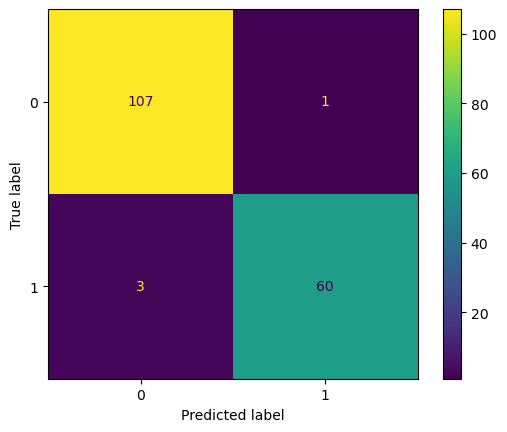

In [29]:
print(classification_report(y_valid, preds))
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

Use SMOTE to fix the slight imbalance it the dataset.

<Axes: ylabel='diagnosis'>

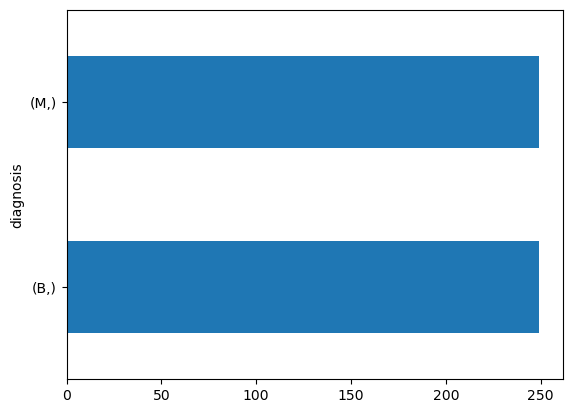

In [32]:
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled.value_counts().plot(kind='barh')

In [37]:
model = LGBMClassifier(n_estimators=300)
model.fit(X_resampled, y_resampled)
preds = model.predict(X_valid)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 249, number of negative: 249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5159
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Using SMOTE did not improve performance.

              precision    recall  f1-score   support

           B       0.96      0.98      0.97       108
           M       0.97      0.94      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



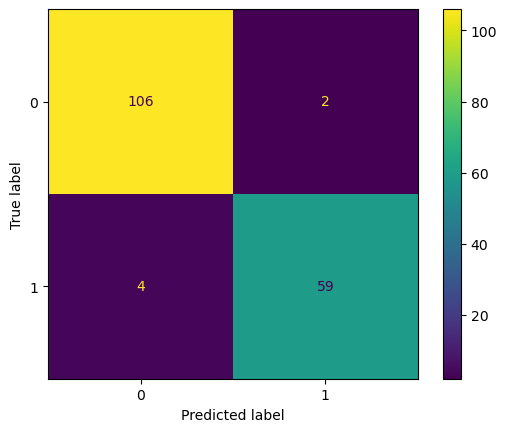

In [38]:
print(classification_report(y_valid, preds))
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

In [70]:
from pydantic import BaseModel, ValidationError, Field

logged_model = 'runs:/e62cb5bd93fd4d12a231ccbb2958254f/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


class Patient(BaseModel):
    id: int = Field(..., description="Unique identifier for the sample")
    radius_mean: float = Field(..., description="Mean radius of the tumor")
    texture_mean: float = Field(..., description="Mean texture of the tumor")
    perimeter_mean: float = Field(..., description="Mean perimeter of the tumor")
    area_mean: float = Field(..., description="Mean area of the tumor")
    smoothness_mean: float = Field(..., description="Mean smoothness of the tumor")
    compactness_mean: float = Field(..., description="Mean compactness of the tumor")
    concavity_mean: float = Field(..., description="Mean concavity of the tumor")
    concave_points_mean: float = Field(..., alias='concave points_mean', description="Mean concave points of the tumor")
    symmetry_mean: float = Field(..., description="Mean symmetry of the tumor")
    fractal_dimension_mean: float = Field(..., description="Mean fractal dimension of the tumor")
    
    radius_se: float = Field(..., description="Standard error of radius")
    texture_se: float = Field(..., description="Standard error of texture")
    perimeter_se: float = Field(..., description="Standard error of perimeter")
    area_se: float = Field(..., description="Standard error of area")
    smoothness_se: float = Field(..., description="Standard error of smoothness")
    compactness_se: float = Field(..., description="Standard error of compactness")
    concavity_se: float = Field(..., description="Standard error of concavity")
    concave_points_se: float = Field(..., alias='concave points_se',description="Standard error of concave points")
    symmetry_se: float = Field(..., description="Standard error of symmetry")
    fractal_dimension_se: float = Field(..., description="Standard error of fractal dimension")

    radius_worst: float = Field(..., description="Worst radius of the tumor")
    texture_worst: float = Field(..., description="Worst texture of the tumor")
    perimeter_worst: float = Field(..., description="Worst perimeter of the tumor")
    area_worst: float = Field(..., description="Worst area of the tumor")
    smoothness_worst: float = Field(..., description="Worst smoothness of the tumor")
    compactness_worst: float = Field(..., description="Worst compactness of the tumor")
    concavity_worst: float = Field(..., description="Worst concavity of the tumor")
    concave_points_worst: float = Field(..., alias='concave points_worst', description="Worst concave points of the tumor")
    symmetry_worst: float = Field(..., description="Worst symmetry of the tumor")
    fractal_dimension_worst: float = Field(..., description="Worst fractal dimension of the tumor")


print(sample_row)
patient = Patient(**sample_row)
inputs = pd.DataFrame([patient.model_dump(by_alias=True)])
pred = loaded_model.predict(inputs)[0]
pred

{'id': 842302.0, 'radius_mean': 17.99, 'texture_mean': 10.38, 'perimeter_mean': 122.8, 'area_mean': 1001.0, 'smoothness_mean': 0.1184, 'compactness_mean': 0.2776, 'concavity_mean': 0.3001, 'concave points_mean': 0.1471, 'symmetry_mean': 0.2419, 'fractal_dimension_mean': 0.07871, 'radius_se': 1.095, 'texture_se': 0.9053, 'perimeter_se': 8.589, 'area_se': 153.4, 'smoothness_se': 0.006399, 'compactness_se': 0.04904, 'concavity_se': 0.05373, 'concave points_se': 0.01587, 'symmetry_se': 0.03003, 'fractal_dimension_se': 0.006193, 'radius_worst': 25.38, 'texture_worst': 17.33, 'perimeter_worst': 184.6, 'area_worst': 2019.0, 'smoothness_worst': 0.1622, 'compactness_worst': 0.6656, 'concavity_worst': 0.7119, 'concave points_worst': 0.2654, 'symmetry_worst': 0.4601, 'fractal_dimension_worst': 0.1189}


'M'

In [69]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        patient = Patient(**request.json) 
        inputs = pd.DataFrame([patient.model_dump(by_alias=True)])
        pred = loaded_model.predict(inputs)[0]

        response = {
            'prediction': pred
        }

        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
[2024-10-28 08:56:28,124] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^